In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [ ]:
import pygad
import torch
import pickle
import json
import pandas as pd
import numpy as np
from modules.functions import data_generator_vec, check_cuda
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt


In [ ]:
model_path = 'saved_models'
if os.path.exists(os.path.join(model_path, 'GAN_generator.pt')):
    generator = torch.jit.load(os.path.join(model_path, 'GAN_generator.pt'), map_location='cpu')
else:
    print('train model first!')

el_list_loc = 'misc/element_order_uts.pkl'
with open(el_list_loc,'rb') as fid:
    el_list = pickle.load(fid)

with open('misc/scaler_y.pkl','rb') as fid:
    uts_scaler = pickle.load(fid)

with open('misc/starting_comp.json','r') as fid:
    json_dict = json.load(fid)

In [ ]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)
to_train_df = dataset[dataset['uts1200C']>0].copy()
comp_dset = data_generator_vec(to_train_df['Composition'], el_list=el_list)
vec_comps = comp_dset.real_data
y = to_train_df['uts1200C'].values.reshape(-1,1).astype('float32')
y_scaled = uts_scaler.transform(y)
kde = KernelDensity(kernel='gaussian',bandwidth=0.5)
v = kde.fit(y_scaled)

def prop_sampler(n_samples):
    return kde.sample(n_samples).astype('float32')

def noise_sampler(N, z_dim):
    return np.random.normal(size=[N, z_dim]).astype('float32')

latent_dim = 4

In [ ]:
desired_uts = np.array(json_dict['start_uts']).reshape(-1,1).astype('float32')
scaled_desired_uts = uts_scaler.transform(desired_uts)
def ga_inputs(N, z_dim = latent_dim):
    #prop = torch.from_numpy(scaled_desired_uts)*torch.ones((N,1))
    noise = torch.from_numpy(noise_sampler(N,z_dim))
    return noise

desired_output = np.array(json_dict['start_comp'])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def fitness_func(solution, solution_idx):
    solution = torch.from_numpy(solution.reshape(-1,latent_dim).astype('float32'))
    prop_input = torch.from_numpy(scaled_desired_uts*np.ones((solution.shape[0],1)).astype('float32'))
    with torch.no_grad():
        output = generator(solution,prop_input)
    #idx = np.argwhere(np.array(json_dict['start_comp'])==0)
    #output[:,idx] = 0
    #weights = np.abs(output - desired_output)
    distance = mean_absolute_error(output.flatten(),desired_output.flatten())
    fitness = 1/distance #- (1-np.sum(output))
    return fitness

In [ ]:
fitness_function = fitness_func

num_generations = 5000
num_parents_mating = 2

sol_per_pop = 20
num_genes = latent_dim

initial_population = ga_inputs(1000)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "adaptive"
mutation_probability = (0.3,0.05)
mutation_percent_genes = (20,5)

In [ ]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       mutation_probability=mutation_probability,
                       initial_population=initial_population)
ga_instance.run()

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()

In [ ]:
solution = torch.from_numpy(solution.reshape(-1,latent_dim).astype('float32'))
prop_input = torch.from_numpy(scaled_desired_uts*np.ones((solution.shape[0],1)).astype('float32'))
out = generator(solution,prop_input)
plt.imshow(out.to('cpu').detach().numpy())

In [ ]:
out

In [ ]:
plt.imshow(np.array(json_dict['start_comp']).reshape(1,-1))

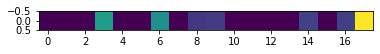

In [68]:
plt.imshow(np.array(json_dict['start_comp']).reshape(1,-1))